# Exercise 08 RNN & LSTM - Assignment

<span style="color:red">**The submission deadline of this assignment is 23/04/2024 23:59.**</span>

<span style="color:red">**Do not submit the saved `.pth` file of the trained CNN, because the file size is too big.**</span>

## Pedagogy

This notebook contains both theoretical explanations and executable cells to execute your code.

When you see the <span style="color:red">**[TBC]**</span> (To Be Completed) sign, it means that you need to perform an action else besides executing the cells of code that already exist. These actions can be:
- Complete the code with proper comments
- Respond to a question
- Write an analysis
- etc.

## Requirement

In this assignment, you are required to build a text-classifier using LSTM.

The problem to be solved is to predict the class of a product based on the product page (title and description) on the E-commerce platform:

|Class|Example product page|
|-|-|
|Books|Inner Engineering: A Yogi's Guide to Joy About the Author Sadhguru Jaggi VasudevSADHGURU is a yogi, mystic, and visionary who established the Isha Foundation, a nonprofit dedicated to the cultivation of human potential...|
|Clothing & Accessories|Amour Butterfly Design Sunglasses For Girls 6+ Years { SKU16 } Amour Butterfly Design Sunglasses to give full protection. Very light weight. Highly durable. Its safe for kids eyes and give full eye protection against harmful uv rays...|
|Electronics|Bluetooth Dongle USB CSR 4.0 Adapter Receiver Transfer Wireless Adapter for PC Computer Laptop Supports Windows 10 8.1 8 7 Vista XP - Upgraded Version...|
|Household|Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch...|

<span style="color:red">**[TBC]**</span> Please complete the following tasks:
- Build the data pipeline
- Create a LSTM-based text classifier
- Train the network, save and reload the best one
- Test and evaluation
- Make predictions on unseen text (defined by yourself)

## Import libraries

In [1]:
# import libraries
import os
import datetime
import warnings

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import classification_report

from torch import nn
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.utils.data.dataset import random_split

from torchtext.data.utils import get_tokenizer # for tokenization
from torchtext.vocab import build_vocab_from_iterator # for creating vocabulary


In [2]:
# suppress all warnings
warnings.filterwarnings("ignore")

## Task 1. Build the data pipeline

You are required to use `ecommerce_dataset.csv` which can be downloaded from the Learn Platform.

<span style="color:red">**[TBC]**</span> You need to:
- Load the dataset from the `ecommerce_dataset.csv` file
- Tokenization
- Create the vocabulary
- Cut/Pad each news articles to the same sequence length
- Create the tensor dataset and dataloader for the training, validation, and test set

In [3]:
# Importing Data

ecomerce_data = 'https://raw.githubusercontent.com/Jhonnatan7br/AI-M.L-D.L-and-LLM/main/2.%20Deep_Learning%20-%20Guides%20-%20Tianyuan%20ZHANG%20ML%20Course/data/RNN%20sets/ecommerce_dataset.csv'
ecomerce_data = pd.read_csv(ecomerce_data,  sep=",")

ecomerce_data

,text,label
0,Paper Plane Design Framed Wall Hanging Motivat...,3
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",3
2,SAF 'UV Textured Modern Art Print Framed' Pain...,3
3,"SAF Flower Print Framed Painting (Synthetic, 1...",3
4,Incredible Gifts India Wooden Happy Birthday U...,3
...,...,...
50419,Strontium MicroSD Class 10 8GB Memory Card (Bl...,2
50420,CrossBeats Wave Waterproof Bluetooth Wireless ...,2
50421,Karbonn Titanium Wind W4 (White) Karbonn Titan...,2
50422,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou...",2


In [ ]:
###

In [4]:
# get the tokenizer
tokenizer = get_tokenizer('basic_english')

# define an intertor function to perform tokenization
def yield_tokens(df, tokenizer):
    for i in range(len(df)):
        yield tokenizer(df['text'].values[i])

# create the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(ecomerce_data, tokenizer), specials = ['<unk>'])
vocab.set_default_index(vocab['<unk>'])

# Map classes to numerical labels
class_to_label = {
    'Books': 0,
    'Clothing & Accessories': 1,
    'Electronics': 2,
    'Household': 3
}

In [5]:
# print the number of unique tokens in the vocabulary
print('The number of unique tokens in the vocabulary:', len(vocab))

The number of unique tokens in the vocabulary: 110481


In [6]:
# cut/pad all news articles to the same sequence length
seq_length = 20 # number of tokens in the sequence for each news articles
X = []
for i in range(len(ecomerce_data)):
    text = ecomerce_data['text'].values[i]
    text = vocab(tokenizer(text))
    if len(text) < seq_length:
        text = text + [0] * (seq_length - len(text)) # pad the sequence with 0
    else:
        text = text[:seq_length] # cut the sequence to the pre-defined length
    X.append(text)
X = np.array(X)
print('The shape of input:', X.shape)
y = ecomerce_data['label'].values
print('The shape of label:', y.shape)

The shape of input: (50424, 20)
The shape of label: (50424,)


In [7]:
# create the tensor dataset
ecomerce_data = TensorDataset(
    torch.tensor(X, dtype = torch.int64),
    torch.tensor(y, dtype = torch.int64)
)

In [8]:
# split the dataset into the training, validation, and test set
total_count = len(ecomerce_data)
train_count = int(0.7 * total_count)
val_count = int(0.2 * total_count)
test_count = total_count - (train_count + val_count)

train_ds, val_ds, test_ds = random_split(ecomerce_data, [train_count, val_count,test_count])

In [ ]:
# split the dataset into the training, validation, and test set
"""train_val_ds, test_ds = random_split(ag_news_ds, [0.7, 0.3])
train_ds, val_ds = random_split(train_val_ds, [0.8, 0.2])"""

'train_val_ds, test_ds = random_split(ag_news_ds, [0.7, 0.3])\ntrain_ds, val_ds = random_split(train_val_ds, [0.8, 0.2])'

In [9]:
# create the training, validation, and test data loaders
batch_size = 512 # usually set to 2 to the nth power
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False)

In [11]:
# get one batch and print its shape
for batch in train_dl:
    print(batch[0].shape)
    print(batch[1].shape)
    break

torch.Size([512, 20])
torch.Size([512])


In [12]:
# get one batch and print its shape
for batch in val_dl:
    print(batch[0].shape)
    print(batch[1].shape)
    break

torch.Size([512, 20])
torch.Size([512])


## Task 2. Create a text-classifier using LSTM.

<span style="color:red">**[TBC]**</span> You need to:
- Define a custom class to specify the structure and the forward method of the network
    - You are required to use `nn.LSTM()` layer in the network
- Specify the device used for computation
- Create an instance of the network and move it to the corresponding device

In [13]:
class LSTMClassifier(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_size, num_class, num_layers=1, bidirectional=False, dropout=0.02):
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers=num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, num_class)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        lstm_output, (hidden, cell) = self.lstm(embedded)
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        output = self.fc(hidden)
        return output


In [14]:
# get cpu, gpu or mps device for computation
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [16]:
# Create the neural network
# Create an instance of the network and move it to the corresponding device
vocab_size = len(vocab)
embedding_dim = 64  # Adjust as per your choice
hidden_size = 32  # Adjust as per your choice
num_class = len(class_to_label)  # Number of classes
num_layers = 2  # Number of LSTM layers
bidirectional = True  # Whether to use bidirectional LSTM
dropout = 0.2  # Dropout probability

model = LSTMClassifier(vocab_size, embedding_dim, hidden_size, num_class, num_layers, bidirectional, dropout).to(device)

## Task 3. Train the network, save and reload the best one

<span style="color:red">**[TBC]**</span> You need to:
- Define a `train()` function
    - <span style="color:red">**Do not submit the saved file as it will be too big.**</span>
- Train the network
- Reload the best model after training
- Plot the loss history of the training process

In [17]:
from datetime import datetime

def train(model, train_dl, val_dl, optimizer, criterion, num_epochs=10, device='cpu', save_path='best_model.pt', early_stopping_patience=10, lr_scheduler=None):
    train_losses = []
    val_losses = []
    min_val_loss = float('inf')
    patience_counter = 0
    saved_path = save_path

    for epoch in range(num_epochs):
        start_time = datetime.now()
        model.train()
        train_loss = 0.0
        for batch in train_dl:
            optimizer.zero_grad()
            inputs = batch[0].to(device)  # Accessing input data
            labels = batch[1].to(device)  # Accessing labels
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_epoch_loss = train_loss / len(train_dl.dataset)
        train_losses.append(train_epoch_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_dl:
                inputs = batch[0].to(device)  # Accessing input data
                labels = batch[1].to(device)  # Accessing labels
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
            val_epoch_loss = val_loss / len(val_dl.dataset)
            val_losses.append(val_epoch_loss)

            end_time = datetime.now()
            time_consumed = str(end_time - start_time).split('.')[0]
            print(f"Epoch {epoch + 1}: train loss = {train_epoch_loss:>5f}, val loss = {val_epoch_loss:>5f}, time consumed = {time_consumed}")

            current_lr = optimizer.param_groups[0]['lr']
            if lr_scheduler is not None:
                lr_scheduler.step(val_epoch_loss)
                if current_lr != optimizer.param_groups[0]['lr']:
                    print(f'Learning rate reduced after epoch {epoch+1}')

            if val_epoch_loss < min_val_loss:
                min_val_loss, patience_counter = val_epoch_loss, 0
                if os.path.exists(saved_path):
                    os.remove(saved_path)
                time_str = end_time.strftime("%Y-%m-%d_%H-%M-%S")
                saved_path = f'epoch_{epoch+1}_val_loss_{val_epoch_loss:>4f}_{time_str}.pth'
                torch.save(model.state_dict(), saved_path)
                print(f'Model saved after epoch {epoch+1}')
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print('Early stopping!')
                    break

    return train_losses, val_losses


In [ ]:
"""
# Define training hyperparameters
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-1
weight_decay = 1e-5
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)
epochs = 1000
early_stopping_patience = 10
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5
)

# Train the Network
train_losses, val_losses = train(model, train_dl, val_dl, optimizer, loss_fn, num_epochs=epochs, device=device, early_stopping_patience=early_stopping_patience, lr_scheduler=lr_scheduler)
"""

In [19]:
import torch
import torch.nn as nn

# Define training hyperparameters
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.0000001  # Adjusted initial learning rate
weight_decay = 1e-10  # Reduced weight decay
optimizer = torch.optim.Adam(  # Changed optimizer to Adam
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)
epochs = 50
early_stopping_patience = 2  # Reduced patience for early stopping
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=3  # Adjusted patience for LR scheduler
)

# Train the Network
train_losses, val_losses = train(model, train_dl, val_dl, optimizer, loss_fn, num_epochs=epochs, device=device, early_stopping_patience=early_stopping_patience, lr_scheduler=lr_scheduler)



Epoch 1: train loss = 1.369756, val loss = 1.369096, time consumed = 0:00:22
Model saved after epoch 1
Epoch 2: train loss = 1.369690, val loss = 1.369062, time consumed = 0:00:22
Model saved after epoch 2
Epoch 3: train loss = 1.369831, val loss = 1.369028, time consumed = 0:00:22
Model saved after epoch 3
Epoch 4: train loss = 1.369644, val loss = 1.368995, time consumed = 0:00:21
Model saved after epoch 4
Epoch 5: train loss = 1.369685, val loss = 1.368961, time consumed = 0:00:25
Learning rate reduced after epoch 5
Model saved after epoch 5
Epoch 6: train loss = 1.369837, val loss = 1.368957, time consumed = 0:00:21
Model saved after epoch 6
Epoch 7: train loss = 1.369631, val loss = 1.368954, time consumed = 0:00:20
Model saved after epoch 7
Epoch 8: train loss = 1.369780, val loss = 1.368951, time consumed = 0:00:22
Model saved after epoch 8
Epoch 9: train loss = 1.369669, val loss = 1.368947, time consumed = 0:00:21
Model saved after epoch 9
Epoch 10: train loss = 1.369856, val 

In [62]:
import os

best_model_path = '/content/epoch_9_val_loss_1.369130_2024-04-19_09-40-15.pth'
if os.path.exists(best_model_path):
    best_model.load_state_dict(torch.load(best_model_path))
    best_model.eval()
    print("Best model loaded successfully.")
else:
    print(f"Error: '{best_model_path}' not found.")


Best model loaded successfully.


In [31]:

# Reload the best model after training
best_model = LSTMClassifier(vocab_size, embedding_dim, hidden_size, num_class, num_layers, bidirectional, dropout).to(device)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()


LSTMClassifier(
  (embedding): Embedding(110481, 64)
  (lstm): LSTM(64, 32, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

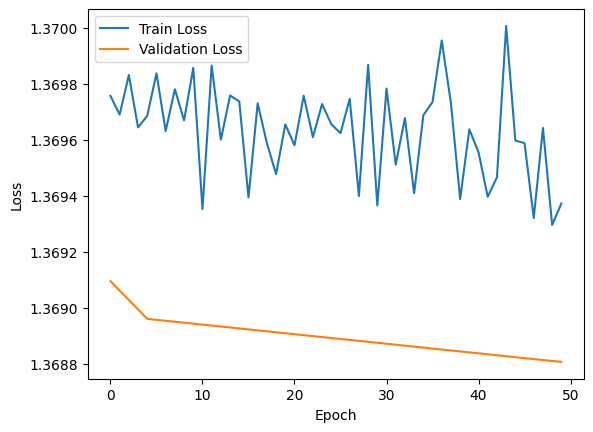

In [64]:
# Plot the loss history
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# NOTE: With more epochs the model will improve its performance

## Task 4. Test and evaluation

<span style="color:red">**[TBC]**</span> You need to:
- Define the `test()` function
    - Output logits, probabilities and predictions
    - Output the loss value on the test set
- Make predictions on the test dataset
- Evaluate the performance
    - Use `sklearn.metrics.classification_report()`

In [33]:
# Test Function to make predictions

def test(dataloader, model, loss_fn):
    logits, probs, preds = [], [], []
    with torch.no_grad():
        loss = 0.0
        for (X, y) in dataloader:
            X, y = X.to(device), y.to(device) # move data to GPU
            batch_logits = model(X)
            batch_loss = loss_fn(batch_logits, y)
            loss += batch_loss.item()

            batch_probs = torch.softmax(batch_logits, dim = -1)
            _, batch_preds = torch.max(batch_logits, 1)

            logits.append(batch_logits.cpu().numpy())
            probs.append(batch_probs.cpu().numpy())
            preds.append(batch_preds.cpu().numpy())
        loss /= len(dataloader)
        print(f"test loss = {loss}")
    return np.concatenate(logits), np.concatenate(probs), np.concatenate(preds), loss

## Task 5. Make predictions on unseen text

<span style="color:red">**[TBC]**</span> You need to:
- Specify an unseen product page by yourself
    - Use a real product page on the ecommerce platform as Amazon
    - Or make up a fake one yourself
- Define a `predict()` function for making predictions
- Use the `predict()` function to classify the product page into one of the pre-defined classes

In [60]:
import torch

def predict(model, dataloader, class_to_label, device='cpu'):
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs in dataloader:
            input_ids = inputs[0].to(device)
            outputs = model(input_ids)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())

    predicted_labels = [label for pred in predictions for label, idx in class_to_label.items() if idx == pred]
    return predicted_labels

In [67]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from transformers import BertTokenizer

# Define the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define the made-up product page text
product_page_text = """
**Product Name**: CleanSweep Robot Vacuum

**Description**:
The CleanSweep Robot Vacuum is your reliable partner in keeping your home clean and tidy effortlessly. With its cutting-edge technology and efficient design, it takes the hassle out of vacuuming, allowing you to spend more time doing what you love. Experience the convenience of automated cleaning with the CleanSweep Robot Vacuum.

**Features**:
- Smart navigation: Utilizes advanced sensors to map out your home and navigate around obstacles with ease.
- Powerful suction: Equipped with a high-performance motor and brushes to efficiently capture dust, dirt, and debris from all floor types.
- Wi-Fi connectivity: Control and schedule cleaning sessions from anywhere using your smartphone or smart home device.
- Multi-surface cleaning: Easily transitions between hardwood floors, carpets, and rugs for thorough cleaning.
- Self-charging: Automatically returns to its charging dock when the battery is low, ensuring it's always ready for the next cleaning cycle.
- Edge cleaning: Specialized brushes clean along walls and edges, reaching into corners and tight spaces for a comprehensive clean.
- Virtual barriers: Set up virtual walls or no-go zones to restrict areas where the robot should not clean.
- Low-profile design: Sleek and slim design allows the robot vacuum to clean under furniture and hard-to-reach areas with ease.

**Specifications**:
- Cleaning modes: Auto, spot clean, edge clean
- Battery capacity: 2600mAh lithium-ion battery
- Dustbin capacity: 500ml
- Connectivity: Wi-Fi 802.11 b/g/n
- Sensors: Anti-collision sensors, drop sensors, cliff detection sensors
- Compatibility: Compatible with iOS 10.0 and above, Android 5.0 and above
- Dimensions: 330mm diameter, 76mm height
- Weight: 3.5 kg
"""


# Tokenize the product page text
tokenized_text = tokenizer(product_page_text, padding=True, truncation=True, return_tensors='pt')

# Create a DataLoader for the tokenized text
test_product_dl = DataLoader([tokenized_text], batch_size=1)

# Extract input tensors from the tokenized text
input_ids = tokenized_text['input_ids']
attention_mask = tokenized_text['attention_mask']

# Create a DataLoader for the input tensors
test_product_dl = DataLoader([(input_ids)], batch_size=1)

# Call the predict function
predicted_labels = predict(model, test_product_dl, class_to_label)

# Print the predicted labels
print("Predicted Category:", predicted_labels[0])


Predicted Category: Household
